# Introduction 

As social media has become an important part of many people's lives for keeping in touch with their friends and family, it has also become a crucial communication channel during times of emergency. It allows individuals to announce observed emergencies in real-time. This project aims to monitor, analyze, and determine which tweets are or aren't related to disasters.

In [459]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import re
import string
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN, GRU
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [262]:
test_df = pd.DataFrame(pd.read_csv('test.csv'))
train_df = pd.DataFrame(pd.read_csv('train.csv'))

In [263]:
# data structure
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [264]:
# data size and dimension
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [265]:
#Check for null count
a = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']
null_counts = []
for c in train_df.columns:
    string_null = np.array([x in a[2:] for x in train_df[c]])
    null_count = {
        'column': c,
        'native null count': train_df[c].isnull().sum(),
        'non-native null count': string_null.sum()
    }
    null_counts.append(null_count)
    print (null_count)

{'column': 'id', 'native null count': 0, 'non-native null count': 0}
{'column': 'keyword', 'native null count': 61, 'non-native null count': 0}
{'column': 'location', 'native null count': 2533, 'non-native null count': 4}
{'column': 'text', 'native null count': 0, 'non-native null count': 0}
{'column': 'target', 'native null count': 0, 'non-native null count': 0}


# Exploratory Data Analysis

I will be focusing on the text column and the null values in the 'keyword' and 'location' columns are not important for my feature engineering tasks, I will proceed with my feature engineering without considering those null values.

Text(0.5, 1.0, 'Class distribution')

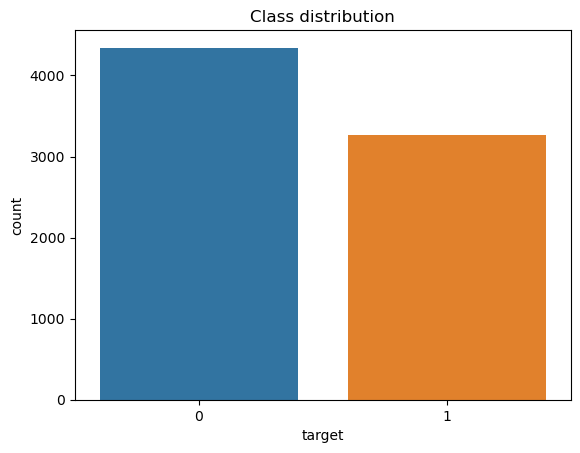

In [266]:
sns.countplot(train_df, x='target')
plt.title("Class distribution")

The dataset is not balance, this might create some problems including biased model performance. We will try to balance this dataset so they have the equal amount of positive and negative data.

Text(0.5, 1.0, 'Class Distribution')

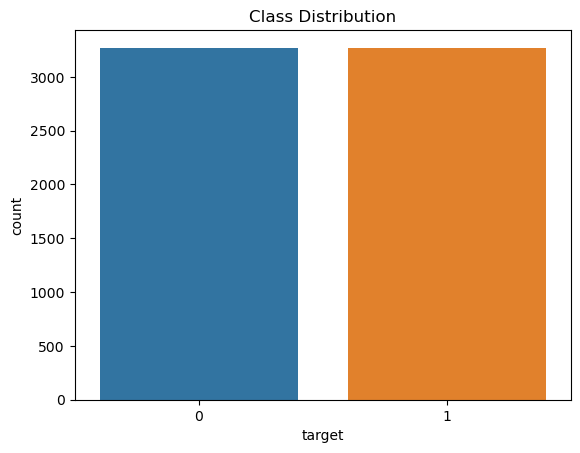

In [267]:
pos_labels = train_df[train_df["target"] == 1]
neg_labels = train_df[train_df["target"] == 0]
neg_labels = neg_labels.sample(n = len(pos_labels))

train_df = shuffle(pd.concat([pos_labels, neg_labels]))
train_df = train_df.reset_index(drop=True)
sns.countplot(train_df, x='target')
plt.title("Class Distribution")

In [268]:
# word count
word_count=[]
for i in train_df['text']:
    word_count.append(len(i.split()))
    
train_df['word count']=word_count
train_df

,id,keyword,location,text,target,word count
0,575,arson,"Miami,FL",RelaxInPR: miprv: RT latimes: Arson suspect li...,1,15
1,6318,hostage,NaN,I sent my emails why are the TRINNA hold me ho...,0,15
2,2255,cliff%20fall,NaN,@D33munni @JeanNamibian noooooooo ... *proceed...,0,10
3,4606,emergency%20services,"London, UK",I am not an American but I have family who hav...,1,24
4,9675,tornado,"Fort Knox, KY 40121",@SakhalinTribune Calgary area tornado warnings...,1,10
...,...,...,...,...,...,...
6537,1880,burning,Isle of Man,501 sky news mandem in totteham going maddddd ...,1,16
6538,10149,upheaval,NaN,The Great Upheaval By Winik Jay http://t.co/Ef...,0,8
6539,1353,blown%20up,"Guildford, UK",'WeÛªre blown away by this extension. Nothing...,0,18
6540,2244,chemical%20emergency,NaN,Please stand up for bees against profit-hungry...,0,19


Text(0.5, 1.0, 'Word count distribution between positive and negative tweets')

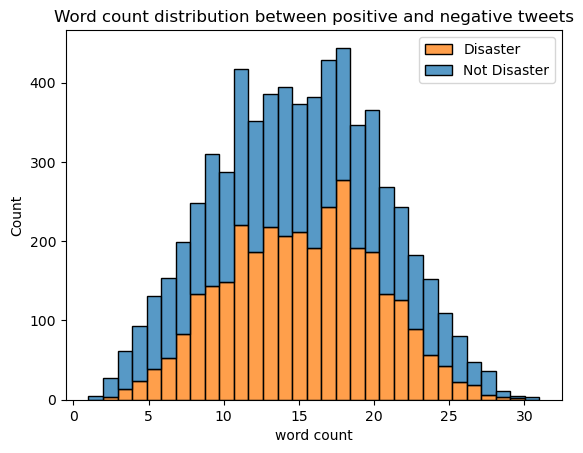

In [269]:
sns.histplot(data=train_df, x="word count", hue="target", multiple='stack', bins=31)
plt.legend(labels=['Disaster', 'Not Disaster'])
plt.title('Word count distribution between positive and negative tweets')

In [516]:
# character count
char_count=[]
for i in train_df['text']:
    char_count.append(len(i))
    
train_df['char count']=char_count
train_df

,id,keyword,location,text,target,word count,char count
0,575,arson,"Miami,FL",relaxinpr miprv rt latim arson suspect link f...,1,15,77
1,6318,hostage,NaN,sent email trinna hold hostag rap,0,15,35
2,2255,cliff%20fall,NaN,jeannamibian noooooooo proceed fall cliff,0,10,43
3,4606,emergency%20services,"London, UK",american famili serv militari work emerg servi...,1,24,53
4,9675,tornado,"Fort Knox, KY 40121",sakhalintribun calgari area tornado warn end t...,1,10,71
...,...,...,...,...,...,...,...
6537,1880,burning,Isle of Man,sky news mandem totteham go maddddd burn fed ...,1,16,63
6538,10149,upheaval,NaN,great upheav winik jay,0,8,24
6539,1353,blown%20up,"Guildford, UK",weûªr blown away extens noth weûªv seen mani...,0,18,60
6540,2244,chemical%20emergency,NaN,pleas stand bee profithungri chemic compani ke...,0,19,74


Text(0.5, 1.0, 'Character count distribution between positive and negative tweets')

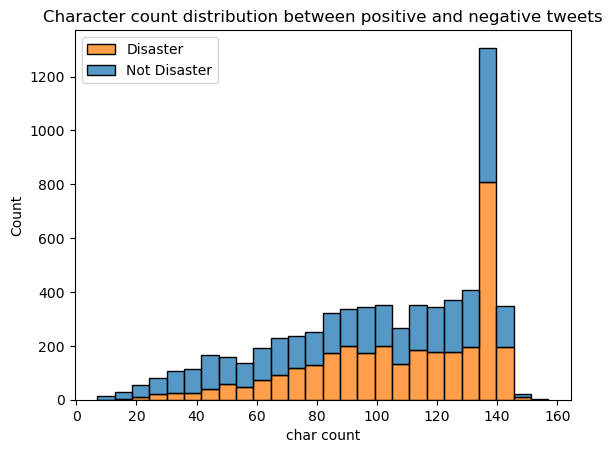

In [271]:
sns.histplot(data=train_df, x="char count", hue="target", multiple='stack')
plt.legend(labels=['Disaster', 'Not Disaster'])
plt.title('Character count distribution between positive and negative tweets')

In [272]:
# reference: https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained/notebook
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [273]:
train_df['text']=train_df['text'].apply(lambda x: clean_text(x))

In [274]:
# Visualize common words
def common_words(text):
    all_text = ' '.join(text)
    tokens = word_tokenize(all_text)
    freq_dist = FreqDist(tokens)
    common_words = freq_dist.most_common(15)  

    for word, frequency in common_words:
        print(word, ':', frequency)
        
common_words(train_df['text'])

the : 2790
a : 1862
in : 1756
to : 1674
of : 1602
and : 1172
i : 1103
is : 787
for : 773
on : 748
you : 649
my : 535
at : 488
with : 479
that : 471


In [293]:
#removing common english stop words
stop_words = stopwords.words('english') + ['like']
def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [284]:
train_df['text']=train_df['text'].apply(lambda x: remove_stopwords(x))

In [294]:
'''We will implement stemming, to reduce derived words to their word stem, base, of root form.
For example : if the word ends in 'ed', remove the 'ed'
if the word ends in 'ing', remove the 'ing'
if the word ends in 'ly', remove the 'ly''''
stemmer = nltk.SnowballStemmer("english")
def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [295]:
train_df['text']=train_df['text'].apply(lambda x: stemm_text(x))

In [299]:
train_df

,id,keyword,location,text,target,word count,char count
0,575,arson,"Miami,FL",relaxinpr miprv rt latim arson suspect link f...,1,15,115
1,6318,hostage,NaN,sent email trinna hold hostag rap,0,15,69
2,2255,cliff%20fall,NaN,jeannamibian noooooooo proceed fall cliff,0,10,68
3,4606,emergency%20services,"London, UK",american famili serv militari work emerg servi...,1,24,139
4,9675,tornado,"Fort Knox, KY 40121",sakhalintribun calgari area tornado warn end t...,1,10,81
...,...,...,...,...,...,...,...
6537,1880,burning,Isle of Man,sky news mandem totteham go maddddd burn fed ...,1,16,82
6538,10149,upheaval,NaN,great upheav winik jay,0,8,77
6539,1353,blown%20up,"Guildford, UK",weûªr blown away extens noth weûªv seen mani...,0,18,142
6540,2244,chemical%20emergency,NaN,pleas stand bee profithungri chemic compani ke...,0,19,143


# Model Architecture

I will be training the model using SimpleRNN, (Long Short-Term Memory), and GRU (Gated Recurrent Unit) . SimpleRNN allows sequential data to be processed by propagating information from previous time steps to the current time step. However, it suffers from the vanishing gradient problem, which hinders the learning process for long sequences. This problem is overcome by LSTM, which incorporates an input gate, a forget gate, and an output gate. These gates enable the flow of information through memory cells, allowing them to retain information from the previous steps. Lastly, GRU simplifies the complexity of LSTM while maintaining performance.

In [321]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_df['text'])
X = word_tokenizer.texts_to_sequences(train_df['text'])
X = pad_sequences(X, maxlen=max(train_df['word count'])) 
y = train_df['target']

In [323]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=151)

In [434]:
def plot(history):
    plt.plot(history.history['accuracy'], 'm', label="train")
    plt.plot(history.history['val_accuracy'], 'b--', label="val")
    plt.title('Train vs. Validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['loss'],'m',label="train")
    plt.plot(history.history['val_loss'], 'b--',label="val" )
    plt.title('Train vs. Validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
def evaluation_metrics(model):
    
    y_pred_prob = model.predict(X_val)
    y_pred = (y_pred_prob >= 0.5).astype(int)

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    return [accuracy, precision, recall, f1]

In [381]:
vocabulary_size=len(word_tokenizer.word_index) + 1
embedding_dim = 100
input_length= max(train_df['word count'])

model1 = Sequential()
model1.add(Embedding(vocabulary_size, embedding_dim, input_length=input_length))
model1.add(LSTM(units=64, dropout=0.2, activation='relu'))
model1.add(Dense(units=1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [382]:
history1 = model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
164/164 [==============================] - 3s 14ms/step - loss: 0.5950 - accuracy: 0.6835 - val_loss: 0.4956 - val_accuracy: 0.7807
Epoch 2/10
164/164 [==============================] - 2s 14ms/step - loss: 0.3567 - accuracy: 0.8555 - val_loss: 0.4696 - val_accuracy: 0.7953
Epoch 3/10
164/164 [==============================] - 2s 14ms/step - loss: 0.2113 - accuracy: 0.9157 - val_loss: 0.7319 - val_accuracy: 0.7746
Epoch 4/10
164/164 [==============================] - 2s 14ms/step - loss: 0.1315 - accuracy: 0.9484 - val_loss: 0.7394 - val_accuracy: 0.7662
Epoch 5/10
164/164 [==============================] - 2s 14ms/step - loss: 0.0882 - accuracy: 0.9643 - val_loss: 1.2344 - val_accuracy: 0.7540
Epoch 6/10
164/164 [==============================] - 2s 15ms/step - loss: 0.0660 - accuracy: 0.9715 - val_loss: 1.0075 - val_accuracy: 0.7624
Epoch 7/10
164/164 [==============================] - 2s 15ms/step - loss: 0.0533 - accuracy: 0.9759 - val_loss: 1.4283 - val_accuracy: 0.7410

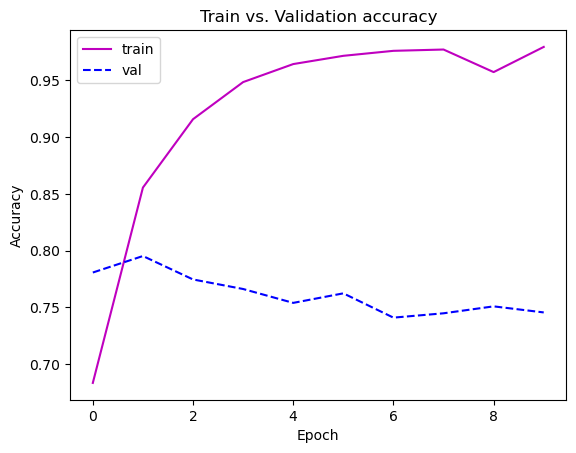

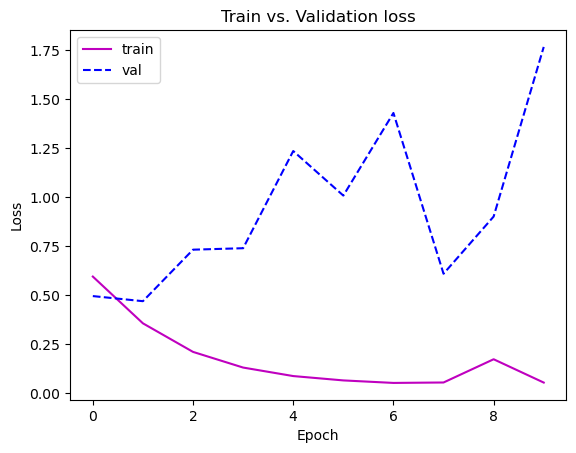

In [446]:
plot(history1)

In [379]:
model2 = Sequential()
model2.add(Embedding(vocabulary_size, embedding_dim, input_length=input_length))
model2.add(SimpleRNN(units=64))
model2.add(Dense(units=64, activation='relu'))
model2.add(Dense(units=1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [380]:
history2 = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
164/164 [==============================] - 1s 6ms/step - loss: 0.6345 - accuracy: 0.6130 - val_loss: 0.5392 - val_accuracy: 0.7212
Epoch 2/10
164/164 [==============================] - 1s 6ms/step - loss: 0.2776 - accuracy: 0.8895 - val_loss: 0.6083 - val_accuracy: 0.7250
Epoch 3/10
164/164 [==============================] - 1s 7ms/step - loss: 0.0900 - accuracy: 0.9723 - val_loss: 0.6712 - val_accuracy: 0.7410
Epoch 4/10
164/164 [==============================] - 1s 7ms/step - loss: 0.0592 - accuracy: 0.9788 - val_loss: 0.7111 - val_accuracy: 0.7135
Epoch 5/10
164/164 [==============================] - 1s 6ms/step - loss: 0.0411 - accuracy: 0.9818 - val_loss: 0.8676 - val_accuracy: 0.6845
Epoch 6/10
164/164 [==============================] - 1s 6ms/step - loss: 0.0331 - accuracy: 0.9807 - val_loss: 0.8511 - val_accuracy: 0.7135
Epoch 7/10
164/164 [==============================] - 1s 6ms/step - loss: 0.0289 - accuracy: 0.9838 - val_loss: 0.9206 - val_accuracy: 0.7181
Epoch 

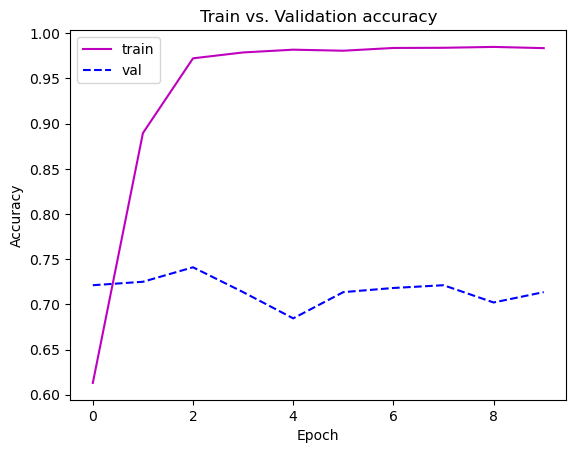

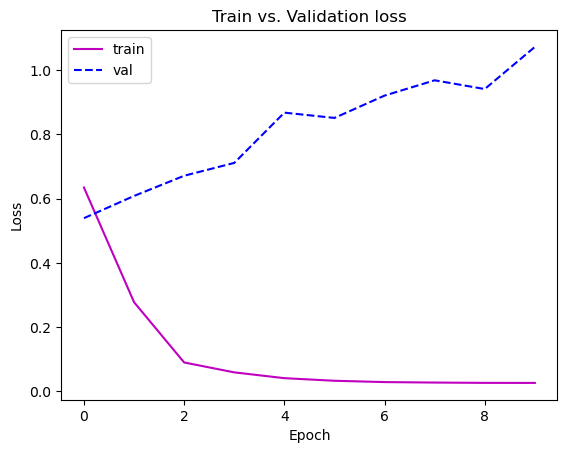

In [447]:
plot(history2)

In [442]:
model3 = Sequential()
model3.add(Embedding(vocabulary_size, embedding_dim, input_length=input_length))
model3.add(GRU(units=64))
model3.add(Dense(units=64, activation='relu'))
model3.add(Dense(units=1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [443]:
history3 = model3.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
164/164 [==============================] - 2s 11ms/step - loss: 0.5439 - accuracy: 0.7111 - val_loss: 0.4720 - val_accuracy: 0.7861
Epoch 2/10
164/164 [==============================] - 2s 10ms/step - loss: 0.2903 - accuracy: 0.8832 - val_loss: 0.4912 - val_accuracy: 0.7823
Epoch 3/10
164/164 [==============================] - 2s 11ms/step - loss: 0.1622 - accuracy: 0.9415 - val_loss: 0.6319 - val_accuracy: 0.7525
Epoch 4/10
164/164 [==============================] - 2s 10ms/step - loss: 0.1072 - accuracy: 0.9625 - val_loss: 0.6429 - val_accuracy: 0.7525
Epoch 5/10
164/164 [==============================] - 2s 11ms/step - loss: 0.0724 - accuracy: 0.9750 - val_loss: 0.7787 - val_accuracy: 0.7510
Epoch 6/10
164/164 [==============================] - 2s 10ms/step - loss: 0.0530 - accuracy: 0.9757 - val_loss: 0.8252 - val_accuracy: 0.7525
Epoch 7/10
164/164 [==============================] - 2s 10ms/step - loss: 0.0384 - accuracy: 0.9815 - val_loss: 0.8839 - val_accuracy: 0.7387

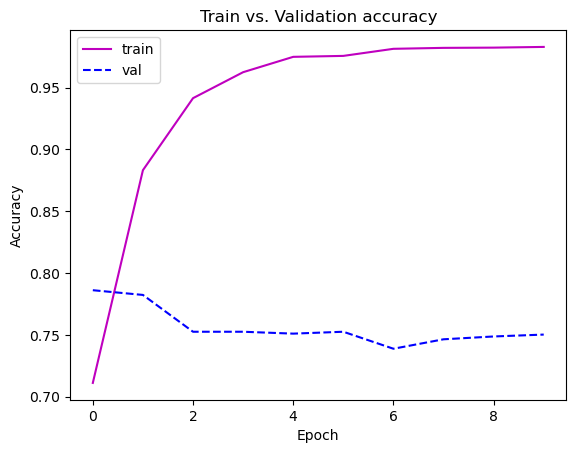

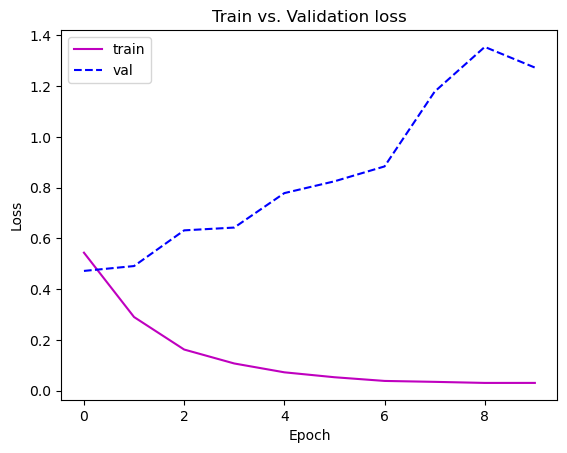

In [448]:
plot(history3)

In [449]:
compare = pd.DataFrame({'model1': evaluation_metrics(model1),
                        'model2': evaluation_metrics(model2), 'model3': evaluation_metrics(model3)})
compare.index = ['accuracy', 'precision', 'recall', 'f1_score']
compare

41/41 [==============================] - 0s 2ms/step


,model1,model2,model3
accuracy,0.745607,0.713522,0.750191
precision,0.752094,0.674293,0.750408
recall,0.708202,0.790221,0.725552
f1_score,0.729488,0.727669,0.737771


For this particular project of detecting disasters through tweets, recall is prioritized in this application. The goal is to minimize false negatives, which means avoiding the omission of actual disaster tweets, even at the cost of some false positives. However, Kaggle submission is based on accuracy, so I will proceed by choosing the model with the highest accuracy score - model3.

# Result and analysis

I will hypertune the learning rate of model3 - GRU to see if the model would improve.

In [450]:
model4 = Sequential()
model4.add(Embedding(vocabulary_size, embedding_dim, input_length=input_length))
model4.add(GRU(units=64))
model4.add(Dense(units=64, activation='relu'))
model4.add(Dense(units=1, activation='sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [451]:
history4 = model4.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
164/164 [==============================] - 3s 12ms/step - loss: 0.5434 - accuracy: 0.7223 - val_loss: 0.4998 - val_accuracy: 0.7754
Epoch 2/10
164/164 [==============================] - 2s 10ms/step - loss: 0.2458 - accuracy: 0.9027 - val_loss: 0.5657 - val_accuracy: 0.7617
Epoch 3/10
164/164 [==============================] - 2s 11ms/step - loss: 0.1074 - accuracy: 0.9593 - val_loss: 0.8865 - val_accuracy: 0.7647
Epoch 4/10
164/164 [==============================] - 2s 10ms/step - loss: 0.0624 - accuracy: 0.9732 - val_loss: 1.1068 - val_accuracy: 0.7380
Epoch 5/10
164/164 [==============================] - 2s 10ms/step - loss: 0.0504 - accuracy: 0.9769 - val_loss: 1.0052 - val_accuracy: 0.7334
Epoch 6/10
164/164 [==============================] - 2s 11ms/step - loss: 0.0473 - accuracy: 0.9769 - val_loss: 1.1994 - val_accuracy: 0.7311
Epoch 7/10
164/164 [==============================] - 2s 10ms/step - loss: 0.0496 - accuracy: 0.9750 - val_loss: 1.3259 - val_accuracy: 0.7319

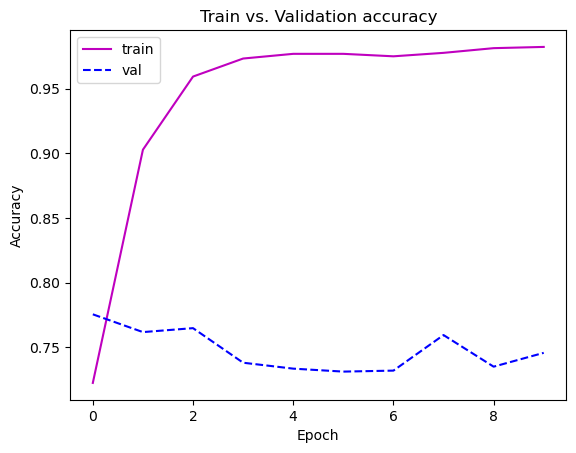

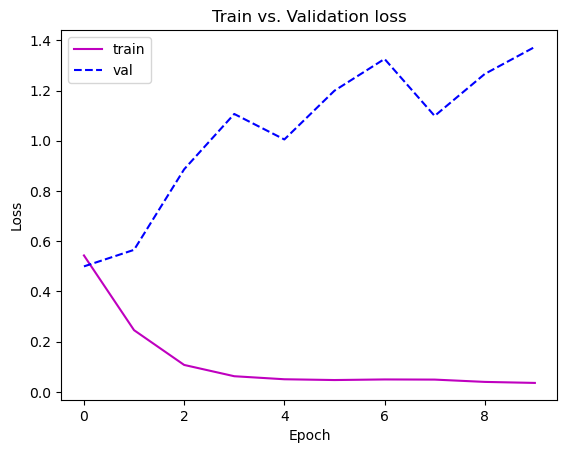

In [454]:
plot(history4)

In [452]:
model5 = Sequential()
model5.add(Embedding(vocabulary_size, embedding_dim, input_length=input_length))
model5.add(GRU(units=64))
model5.add(Dense(units=64, activation='relu'))
model5.add(Dense(units=1, activation='sigmoid'))
model5.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [453]:
history5 = model5.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
164/164 [==============================] - 2s 11ms/step - loss: 0.6916 - accuracy: 0.5668 - val_loss: 0.6891 - val_accuracy: 0.6287
Epoch 2/10
164/164 [==============================] - 2s 10ms/step - loss: 0.6628 - accuracy: 0.7176 - val_loss: 0.6224 - val_accuracy: 0.7150
Epoch 3/10
164/164 [==============================] - 2s 10ms/step - loss: 0.4755 - accuracy: 0.8076 - val_loss: 0.4838 - val_accuracy: 0.7785
Epoch 4/10
164/164 [==============================] - 2s 11ms/step - loss: 0.3073 - accuracy: 0.8800 - val_loss: 0.4896 - val_accuracy: 0.7869
Epoch 5/10
164/164 [==============================] - 2s 11ms/step - loss: 0.2264 - accuracy: 0.9165 - val_loss: 0.5326 - val_accuracy: 0.7785
Epoch 6/10
164/164 [==============================] - 2s 11ms/step - loss: 0.1716 - accuracy: 0.9379 - val_loss: 0.5672 - val_accuracy: 0.7685
Epoch 7/10
164/164 [==============================] - 2s 11ms/step - loss: 0.1299 - accuracy: 0.9555 - val_loss: 0.6517 - val_accuracy: 0.7502

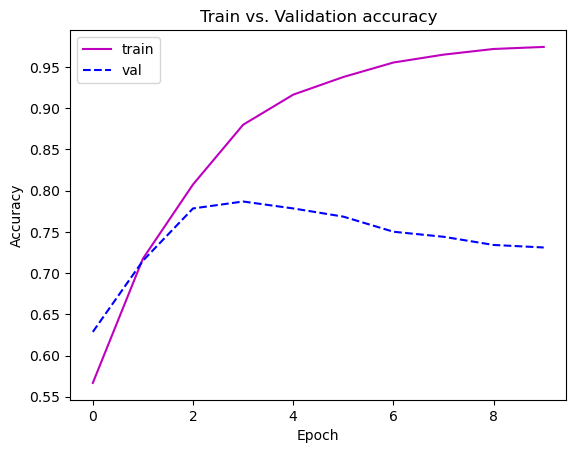

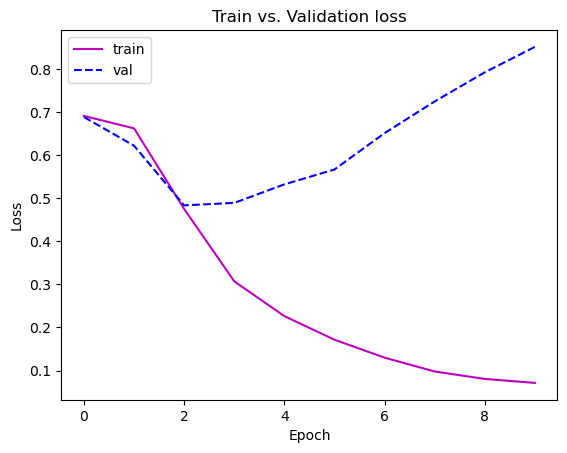

In [455]:
plot(history5)

In [456]:
compare2 = pd.DataFrame({'model4': evaluation_metrics(model1),
                        'model5': evaluation_metrics(model2)})
compare2.index = ['accuracy', 'precision', 'recall', 'f1_score']
compare2

41/41 [==============================] - 0s 1ms/step


,model4,model5
accuracy,0.745607,0.713522
precision,0.752094,0.674293
recall,0.708202,0.790221
f1_score,0.729488,0.727669


In [520]:
X_test = word_tokenizer.texts_to_sequences(test_df['text'])
X_test = pad_sequences(X_test, maxlen=31)

In [521]:
pred = model3.predict(X_test)
pred = np.where(pred >= 0.5, 1, 0)

102/102 [==============================] - 0s 2ms/step


In [522]:
submission = pd.DataFrame({'id': test_df['id'].values, 'target' : np.squeeze(pred.T)})


In [523]:
submission.to_csv('submission.csv', index=False)

In [519]:
test_df['text']=test_df['text'].apply(lambda x: clean_text(x))
test_df['text']=test_df['text'].apply(lambda x: remove_stopwords(x))
test_df['text']=test_df['text'].apply(lambda x: stemm_text(x))

# Conclusion

As we can see, Model 3 or the GRU model with a learning rate of 0.001 produces the best accuracy score for this problem. Hence, I used the GRU model to predict the test set. However, the accuracy score for the test set is not the best (=0.75145). Accuracy score is not the only evaluation metric we should consider. In this particular problem of detecting disasters through tweets, recall is prioritized in this application. The goal is to minimize false negatives, which means avoiding the omission of actual disaster tweets, even at the cost of some false positives. For further study, other languages should also be taken into account during data preprocessing and text cleaning. This could significantly help and improve the accuracy score.

Reference:https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained/notebook